In [26]:
test = pandas.read_csv('data/adn/revision_ids_adn_featured.csv', sep=',')
Xy = test.iloc[:, :-14]

train = pandas.read_csv('data/edit_intention_dataset_featured.csv', sep=',')
Xt,yt = train.iloc[:, :-14], train.iloc[:, -14:]
print(Xt.shape)
print(yt.shape)

scoring = {'Precision': make_scorer(precision_score), 'recall': make_scorer(recall_score),'macro': make_scorer(f1_score,average = 'macro'),
          'micro': make_scorer(f1_score,average = 'micro')}

tuning_rf_precision = []
tuning_rf_recall = []
tuning_rf_f1_macro = []
tuning_rf_f1_micro = []
tuning_rf_best_params = []

models = []

for intention in intentions:
    print(intention)
    reference = joblib.load('trained_models/' + intention + '_classificator.plk')
    
    baseline_model = RandomForestClassifier(random_state = 64, n_estimators = reference.best_params_['classification__n_estimators'])
    
    model = Pipeline([
        ('sampling', ADASYN()),
        ('features', SelectFromModel(
                    RandomForestClassifier(random_state = 64), threshold = reference.best_params_['features__threshold'])),
        ('classification', baseline_model)
    ])
    
    gs_rf_tuned = GridSearchCV(model,
                               param_grid = {},
                      scoring=scoring, cv=4, refit='macro', return_train_score=True)
    gs_rf_tuned.fit(Xt, yt[intention])
    results = gs_rf_tuned.cv_results_
    cv_results_rf_tuning.append(results)
    models.append(gs_rf_tuned)
    print(gs_rf_tuned.predict(Xy))
    
    tuning_rf_precision.append(results['mean_test_Precision'][gs_rf_tuned.best_index_])
    tuning_rf_recall.append(results['mean_test_recall'][gs_rf_tuned.best_index_])
    tuning_rf_f1_micro.append(results['mean_test_micro'][gs_rf_tuned.best_index_])
    tuning_rf_f1_macro.append(results['mean_test_macro'][gs_rf_tuned.best_index_])
    tuning_rf_best_params.append(gs_rf_tuned.best_params_)

    
tuning_rf_model_data = pandas.DataFrame({'Intention':intentions,'Precision':tuning_rf_precision, 'Recall': tuning_rf_recall
                                     , 'F1 micro': tuning_rf_f1_micro
                                     , 'F1 macro': tuning_rf_f1_macro , 'Parameters': tuning_rf_best_params})
tuning_rf_model_data.head(15)
    

(5683, 208)
(5683, 14)
counter-vandalism
[0 0 0 ... 0 0 1]
fact-update
[0 0 0 ... 0 0 0]
refactoring
[0 0 0 ... 0 0 0]
copy-editing
[0 1 0 ... 0 0 0]
wikification
[0 1 0 ... 0 0 0]
vandalism
[0 0 0 ... 0 1 0]
simplification
[0 0 0 ... 0 0 0]
elaboration
[1 0 0 ... 0 0 0]
verifiability
[0 0 0 ... 0 0 0]
process
[0 0 0 ... 0 0 0]
clarification


C:\Users\IgnacioGarcia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[0 0 0 ... 0 0 0]
disambiguation
[0 0 0 ... 0 0 0]
point-of-view


C:\Users\IgnacioGarcia\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[0 0 0 ... 0 0 0]


,Intention,Precision,Recall,F1 micro,F1 macro,Parameters
0,counter-vandalism,0.783875,0.646569,0.989794,0.840959,{}
1,fact-update,0.576969,0.509064,0.945099,0.743913,{}
2,refactoring,0.451396,0.429993,0.959880,0.704782,{}
3,copy-editing,0.641276,0.603464,0.861517,0.766827,{}
4,wikification,0.761337,0.748621,0.794827,0.788692,{}
5,vandalism,0.595927,0.552556,0.974837,0.755569,{}
6,simplification,0.557711,0.493531,0.926095,0.673776,{}
7,elaboration,0.651765,0.748821,0.901812,0.818675,{}
8,verifiability,0.724528,0.769277,0.935245,0.854030,{}
9,process,0.621288,0.494018,0.940700,0.756050,{}


In [27]:
from sklearn.externals import joblib
import os
import shutil
#Remove the already existing trained model (if existing) and create a new folder for the new models
#This way we also guarantee that there wont be redundant models. 
#If you want to keep older models, change them to another folder.
shutil.rmtree('trained_models', ignore_errors=True)
os.mkdir('trained_models')
#Then we just assign the name of the intention and export with joblib extension.
model_index = 0
for intention in intentions:
    joblib.dump(models[model_index], 'trained_models/'+intention+'_classificator.plk')
    model_index += 1

print("Models exported succesfully")

Models exported succesfully


In [1]:
import pandas
import numpy as np
import seaborn as sns
import warnings; warnings.simplefilter('ignore')
from matplotlib import pyplot as plt
from imblearn.over_sampling import ADASYN
from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

corpus = pandas.read_csv('data/corpus/corpus_2.csv', sep=',')
corpus = corpus.sort_values(by = ['timestamp'])
intentionality = corpus['intentionality']
corpus = corpus.drop('intentionality', axis = 1)
corpus.head()

FileNotFoundError: File b'data/corpus/corpus_2.csv' does not exist

In [9]:
intentions = ['counter-vandalism','fact-update','refactoring','copy-editing','wikification',
              'vandalism','simplification','elaboration','verifiability','process','clarification','disambiguation',
              'point-of-view']
intentionality.head()

12814     wikification,elaboration
0                    elaboration  
12815     wikification,elaboration
12816     wikification,elaboration
1        copy-editing,wikification
Name: intentionality, dtype: object

In [14]:
values = {'counter-vandalism':[],'fact-update':[],'refactoring':[],'copy-editing':[],'wikification':[],
              'vandalism':[],'simplification':[],'elaboration':[],'verifiability':[],'process':[],'clarification':[]
          ,'disambiguation':[],'point-of-view':[]}

for intention in intentions:
    count = 0
    for element in intentionality:
        if intention not in element:
            values[intention].append(count)
        else:
            count+=1
            values[intention].append(count)
            
                
    corpus[intention] = values[intention]
        
corpus.head()

,page_id,page_title,page_ns,revision_id,timestamp,contributor_id,org:resource,bytes,counter-vandalism,fact-update,...,copy-editing,wikification,vandalism,simplification,elaboration,verifiability,process,clarification,disambiguation,point-of-view
12814,2730,|Tierra|,0,5697,2001-10-28T02:18:21Z,4850042,|Bradfield|,637,0,0,...,0,1,0,0,1,0,0,0,0,0
0,10058,|Ácido desoxirribonucleico|,0,161,2002-01-11T01:06:09Z,0,|imported>Fidel.G|,276,0,0,...,0,1,0,0,2,0,0,0,0,0
12815,2730,|Tierra|,0,5698,2002-03-21T01:42:29Z,4850063,|Pec|,747,0,0,...,0,2,0,0,3,0,0,0,0,0
12816,2730,|Tierra|,0,5699,2002-05-13T18:29:18Z,43,|AFLastra|,1081,0,0,...,0,3,0,0,4,0,0,0,0,0
1,10058,|Ácido desoxirribonucleico|,0,6683,2002-10-23T09:34:14Z,0,|conversion script|,276,0,0,...,1,4,0,0,4,0,0,0,0,0


In [15]:
corpus.to_csv(path_or_buf = 'data/corpus/corpus_exploratory.csv', index = False)

In [2]:
corpus = pandas.read_csv('data/corpus/editor_count.csv', sep=',')

corpus.head()

,resource,cluster
0,Anonymous,+100
1,|-Erick-|,[5-10)
2,|-antonio-|,1
3,|-jem-|,1
4,|-seb-|,1


In [3]:
import seaborn as sns

categories = corpus['cluster']
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, corpus.iloc['resource'].values.count())
plt.title("Intentions distribution", fontsize=24)
plt.ylabel('Number of revision', fontsize=16)
plt.xlabel('Intention', fontsize=16)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
    # specify integer or string like 'vertical'
    tick.label.set_rotation(30)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(12) 
#adding the text labels
rects = ax.patches
labels = categories
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize = 14)
#plt.xticks(intentions,rotation = 30)

plt.show()

TypeError: cannot do positional indexing on <class 'pandas.core.indexes.range.RangeIndex'> with these indexers [resource] of <class 'str'>

<Figure size 1080x576 with 0 Axes>

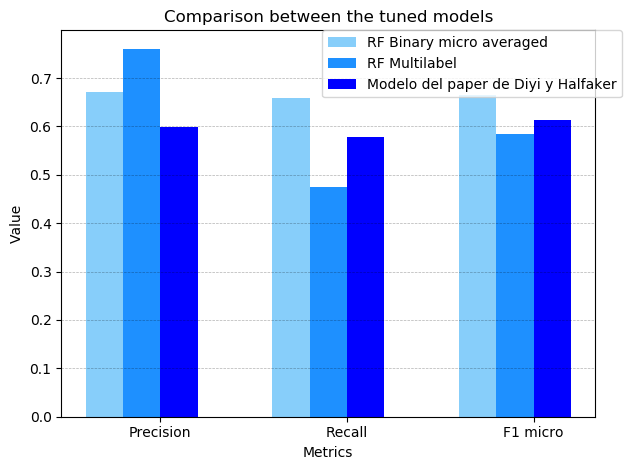

In [9]:
import pandas as pd
import numpy as np
import warnings; warnings.simplefilter('ignore')
from matplotlib import pyplot as plt

plt.rcParams['savefig.dpi'] = 100

sns.reset_orig()



x_labels = ['Precision','Recall','F1 micro']
conclusion = pd.DataFrame()
conclusion['RF Binary'] = [0.670533,0.658465,0.664444]
conclusion['RF Multilabel'] = [0.760734,0.474013,0.584657]
conclusion['Modelo de Diyi y Aaron Halfaker'] = [0.599,0.578,0.613]

length = len(conclusion)
#['RF Binary', 'RF Multilabel', 'KNN Multilabel']
# Set plot parameters
fig, ax = plt.subplots()
width = 0.2 # width of bar
x = np.arange(length)



ax.bar(x, conclusion.iloc[:,0], width, color='#87CEFA', label='RF Binary micro averaged')
ax.bar(x + width, conclusion.iloc[:,1], width, color='#1E90FF', label='RF Multilabel')
ax.bar(x + (2 * width), conclusion.iloc[:,2], width, color='#0000FF', label='Modelo del paper de Diyi y Halfaker')

ax.set_ylabel('Value')

ax.set_xticks(x + width + width/2)
ax.set_xticklabels(x_labels)
ax.set_xlabel('Metrics')
ax.set_title('Comparison between the tuned models')
ax.legend(bbox_to_anchor=(1.05, 1), loc=1, borderaxespad=0.)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)

fig.tight_layout()
plt.show()

In [11]:
conclusion.head()

,Precision,Recall,F1 micro
0,0.670533,0.658465,0.664444
1,0.760734,0.474013,0.584657
